# Modelo de regresión para la predicción de los meses de supervivencia en personas con cancer de pulmon.

## imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.preprocessing import LabelEncoder


In [2]:
ruta_raiz = os.path.abspath(os.path.join(os.getcwd(), ".."))
ruta_modelos = os.path.join(ruta_raiz, 'models')

## Cargamos los datos

In [3]:
# Cargar el dataset procesado que guardamos antes
path_processed = '../data/processed/dataset_procesado_final.csv'
df_ml = pd.read_csv(path_processed)

In [4]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523735 entries, 0 to 523734
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Survival_months         523735 non-null  float64
 1   Stage_Rank              523735 non-null  float64
 2   Rango_Age               523735 non-null  object 
 3   Tumor_Size_Clean        523735 non-null  float64
 4   Grade_Numeric           523735 non-null  float64
 5   Sex_Encoded             523735 non-null  int64  
 6   Race_Encoded            523735 non-null  int64  
 7   Income_Numeric          523735 non-null  float64
 8   Year_of_diagnosis       523735 non-null  int64  
 9   Total_Tumors_Count      523735 non-null  int64  
 10  Is_Multicentric         523735 non-null  int64  
 11  Tumor_Age_Ratio         523735 non-null  float64
 12  Primary_Site_-_labeled  523735 non-null  object 
 13  Chemo_Binary            523735 non-null  int64  
 14  Has_Surgery         

In [5]:
df_ml.shape

(523735, 17)

## Definimos X e y

In [6]:
features_surv_final = [
    # --- Biológicas ---
    'Stage_Rank', 'Rango_Age', 'Tumor_Size_Clean', 'Grade_Numeric',
    'Sex_Encoded', 'Race_Encoded', 'Primary_Site_Encoded',

    # --- Contexto y Carga ---
    'Income_Numeric', 'Year_of_diagnosis', 'Total_Tumors_Count', 'Is_Multicentric',

    # --- Tratamiento ---
    'Has_Surgery', 'Radiation_Binary', 'Triple_Treatment',

    # --- Ingeniería Avanzada ---
    'Tumor_Age_Ratio'] # <--- Agresividad por Órgano

In [7]:
age_map = {
    'Jóvenes (<40)': 0,
    'Adultos (40-60)': 1,
    'Sénior (60-75)': 2,
    'Avanzado (>75)': 3}

# Aplicamos la transformación a la columna que creamos en el EDA
df_ml['Rango_Age_Encoded'] = df_ml['Rango_Age'].map(age_map)

In [8]:
le = LabelEncoder()
df_ml['Primary_Site_Encoded'] = le.fit_transform(df_ml['Primary_Site_-_labeled'].astype(str))

In [9]:
X = df_ml.drop(columns=['Survival_months', 'Primary_Site_-_labeled', 'Rango_Age'])
y = df_ml['Survival_months']

In [10]:
X.shape

(523735, 16)

## Split 80/20

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
X_train.shape[0], X_test.shape[0]

(418988, 104747)

## Random Forest Regression

In [13]:
rf_surv = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1)

In [14]:
rf_surv.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [15]:
y_pred_rf = rf_surv.predict(X_test)

In [16]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

### Métricas RF

In [17]:
metrics_data = {
    'Métrica': ['MAE (Meses)', 'R2 Score', 'RMSE', 'MSE'],
    'Random Forest': [
        mean_absolute_error(y_test, y_pred_rf),
        r2_score(y_test, y_pred_rf),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        mean_squared_error(y_test, y_pred_rf)]}

metrics = pd.DataFrame(metrics_data)
metrics

,Métrica,Random Forest
0,MAE (Meses),12.823655
1,R2 Score,0.491466
2,RMSE,19.602717
3,MSE,384.266530


## XGBoost

In [18]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42)

In [19]:
model_xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [20]:
y_pred_xgb = model_xgb.predict(X_test)

### Métricas

In [21]:
metrics['XGBoost'] = [
    mean_absolute_error(y_test, y_pred_xgb),
    r2_score(y_test, y_pred_xgb),
    np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    mean_squared_error(y_test, y_pred_xgb)]
metrics

,Métrica,Random Forest,XGBoost
0,MAE (Meses),12.823655,12.779899
1,R2 Score,0.491466,0.496013
2,RMSE,19.602717,19.514894
3,MSE,384.266530,380.831093


#### Antiguos resultados, donde olvide agregar variables de tratamiento
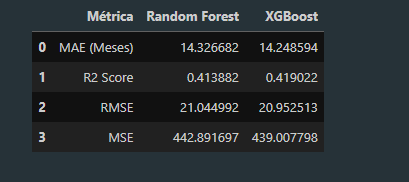

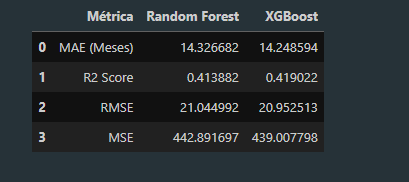

## Importancia de las variables

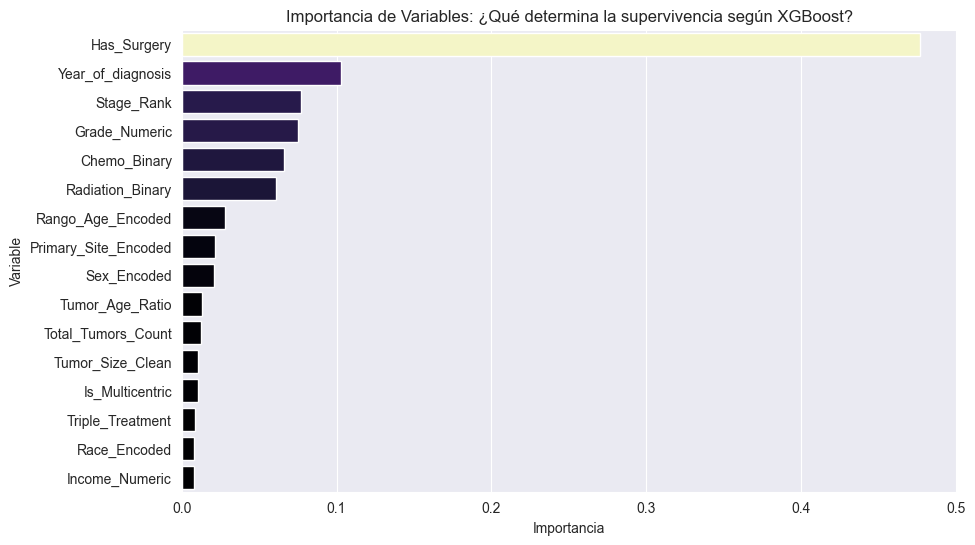

In [22]:
importancias_xgb = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': model_xgb.feature_importances_}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancias_xgb, palette='magma',hue='Importancia',  legend=False)
plt.title('Importancia de Variables: ¿Qué determina la supervivencia según XGBoost?')
plt.show()

## Hiperparametrizacion

In [23]:
param_dist = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]}

In [24]:
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [5, 7, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... ver

In [25]:
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

In [26]:
metrics['XGBoost Tuned'] = [
    mean_absolute_error(y_test, y_pred_best),
    r2_score(y_test, y_pred_best),
    np.sqrt(mean_squared_error(y_test, y_pred_best)),
    mean_squared_error(y_test, y_pred_best)]
metrics

,Métrica,Random Forest,XGBoost,XGBoost Tuned
0,MAE (Meses),12.823655,12.779899,12.740634
1,R2 Score,0.491466,0.496013,0.499062
2,RMSE,19.602717,19.514894,19.455774
3,MSE,384.266530,380.831093,378.527129


#### Antiguos resultados, donde olvide agregar variables de tratamiento

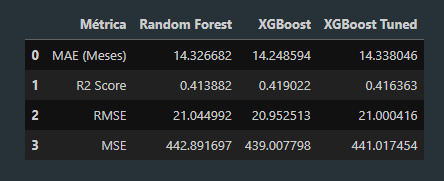

## Visualización de la importancias de las variables

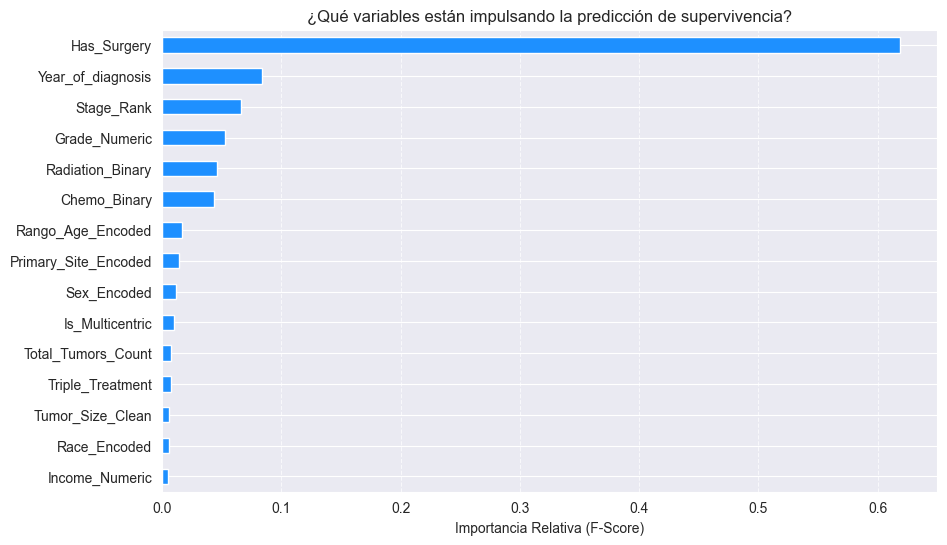

In [27]:
importancias = pd.Series(best_xgb.feature_importances_, index=X.columns)

# Graficamos
plt.figure(figsize=(10, 6))
importancias.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='dodgerblue')
plt.title("¿Qué variables están impulsando la predicción de supervivencia?")
plt.xlabel("Importancia Relativa (F-Score)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Ajustamos algunas variables

### Eras de tratamiento

In [28]:
# 1. Aplicamos las nuevas variables al DataFrame original (df_ml)
df_ml_v2 = df_ml.copy()

# Eras Médicas: 0 (Hasta 2010), 1 (2011-2015), 2 (2016+)
df_ml_v2['Medical_Era'] = pd.cut(df_ml_v2['Year_of_diagnosis'],
                                 bins=[0, 2010, 2015, 2030],
                                 labels=[0, 1, 2]).astype(int)

# Interacción Etapa-Era: Para capturar mejoras en tratamiento por etapa
df_ml_v2['Stage_Era_Interaction'] = df_ml_v2['Stage_Rank'] * (df_ml_v2['Medical_Era'] + 1)

# Edad al cuadrado: El riesgo biológico no es lineal con la edad
df_ml_v2['Age_Squared'] = df_ml_v2['Rango_Age_Encoded'] ** 2

## Volvemos a probar el XGBoost con la nueva variable

In [29]:
X_v2 = df_ml_v2.drop(columns=['Survival_months', 'Primary_Site_-_labeled', 'Rango_Age'])
y_v2 = df_ml_v2['Survival_months']

In [30]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

In [31]:
best_xgb_final = xgb.XGBRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
best_xgb_final.fit(X_train_v2, y_train_v2)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [32]:
y_pred_final = best_xgb_final.predict(X_test_v2)

### Métricas

In [33]:
metrics['XGBoost + Interacciones'] = [
    mean_absolute_error(y_test_v2, y_pred_final),
    r2_score(y_test_v2, y_pred_final),
    np.sqrt(mean_squared_error(y_test_v2, y_pred_final)),
    mean_squared_error(y_test_v2, y_pred_final)]
metrics

,Métrica,Random Forest,XGBoost,XGBoost Tuned,XGBoost + Interacciones
0,MAE (Meses),12.823655,12.779899,12.740634,12.740947
1,R2 Score,0.491466,0.496013,0.499062,0.498761
2,RMSE,19.602717,19.514894,19.455774,19.461622
3,MSE,384.266530,380.831093,378.527129,378.754749


#### Antiguos resultados, donde olvide agregar variables de tratamiento

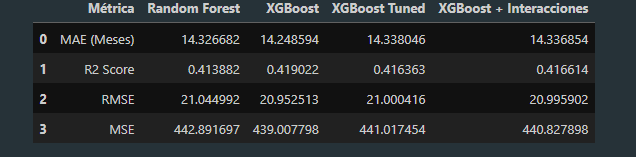

## Transformación de la variable temporal de Survival_Months

In [34]:
# 1. Transformación logarítmica (sumamos 1 para evitar log(0))
y_train_log = np.log1p(y_train_v2)

# 2. Entrenar el modelo con el target transformado
best_xgb_final.fit(X_train_v2, y_train_log)

# 3. Predecir y revertir la transformación (expm1 es el inverso de log1p)
y_pred_log = best_xgb_final.predict(X_test_v2)
y_pred_final_log = np.expm1(y_pred_log)

### Métricas

In [35]:
metrics['XGBoost Log-Transform'] = [
    mean_absolute_error(y_test_v2, y_pred_final_log),
    r2_score(y_test_v2, y_pred_final_log),
    np.sqrt(mean_squared_error(y_test_v2, y_pred_final_log)),
    mean_squared_error(y_test_v2, y_pred_final_log)]
metrics

,Métrica,Random Forest,XGBoost,XGBoost Tuned,XGBoost + Interacciones,XGBoost Log-Transform
0,MAE (Meses),12.823655,12.779899,12.740634,12.740947,12.287773
1,R2 Score,0.491466,0.496013,0.499062,0.498761,0.417436
2,RMSE,19.602717,19.514894,19.455774,19.461622,20.981094
3,MSE,384.266530,380.831093,378.527129,378.754749,440.206305


#### Antiguos resultados, donde olvide agregar variables de tratamiento

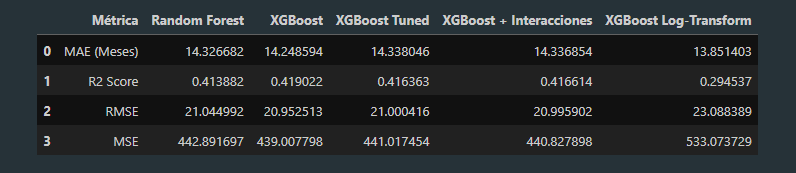

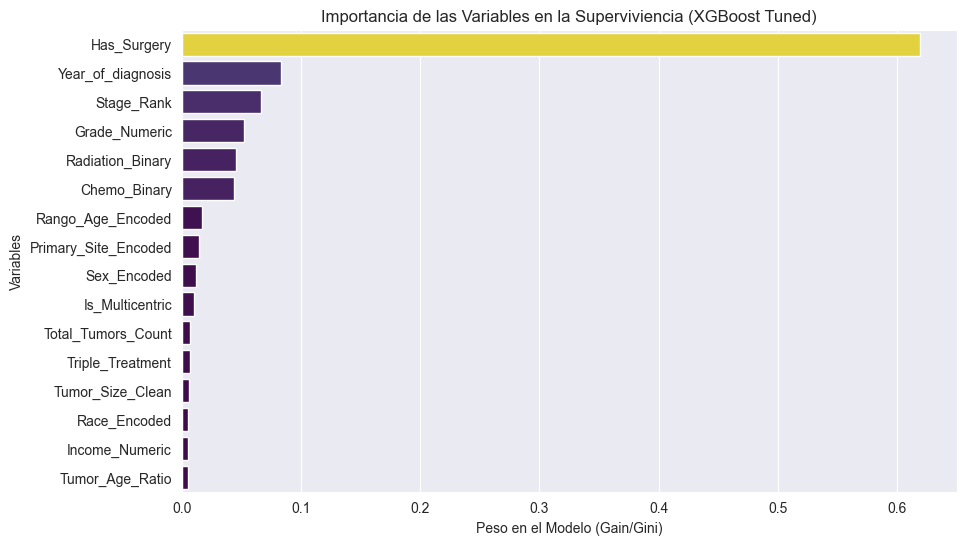

,Feature,Importancia
11,Has_Surgery,0.619011
6,Year_of_diagnosis,0.083410
0,Stage_Rank,0.066430
2,Grade_Numeric,0.052392
12,Radiation_Binary,0.045693
10,Chemo_Binary,0.043547
14,Rango_Age_Encoded,0.017020
15,Primary_Site_Encoded,0.014192
3,Sex_Encoded,0.011814
8,Is_Multicentric,0.010122


In [45]:
# Extraer las importancias
importancias = best_xgb.feature_importances_
nombres_features = X_train.columns

# Crear un DataFrame para visualizarlo mejor (como solicitaste)
df_importancia = pd.DataFrame({
    'Feature': nombres_features,
    'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=df_importancia, palette='viridis', hue='Importancia', legend=False)
plt.title('Importancia de las Variables en la Superviviencia (XGBoost Tuned)')
plt.xlabel('Peso en el Modelo (Gain/Gini)')
plt.ylabel('Variables')
plt.show()

# Mostrar el DataFrame de importancia
display(df_importancia)

## Testing

In [54]:
# 1. Realizar predicciones sobre el conjunto de test (X_test)
y_pred = best_xgb.predict(X_test)

# 2. Crear un DataFrame de comparación para el Testing
df_test_results = pd.DataFrame({
    'Supervivencia_Real': y_test,
    'Supervivencia_Predicha': y_pred,
    'Error_Absoluto': np.abs(y_test - y_pred)})

# 3. Mostrar las primeras 10 comparaciones
df_test_results.head(20)



,Supervivencia_Real,Supervivencia_Predicha,Error_Absoluto
447606,5.0,10.640105,5.640105
500275,0.0,3.141741,3.141741
59333,29.0,14.442911,14.557089
336780,7.0,18.910652,11.910652
240772,105.0,92.522224,12.477776
10407,15.0,15.792531,0.792531
220757,13.0,45.170879,32.170879
274511,58.0,39.607185,18.392815
80990,49.0,44.642426,4.357574
70893,5.0,16.284233,11.284233


In [50]:
# 4. Cálculo de métricas finales de validación
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

metrics_final_test = pd.DataFrame({
    'Métrica': ['MAE (Meses)', 'R2 Score'],
    'Resultado en Test': [mae_test, r2_test]})
metrics_final_test

,Métrica,Resultado en Test
0,MAE (Meses),12.740634
1,R2 Score,0.499062


## Guardamos nuestro mejor modelo

In [56]:
joblib.dump(best_xgb_final, '..\models\modelo_predictivo_mesesV2.joblib')

['..\\models\\modelo_predictivo_mesesV2.joblib']

## Resumen

1. Superioridad del Modelo XGBoost Optimizado

Tras el proceso de experimentación, el modelo XGBoost Tuned se consolidó como el motor predictivo más eficiente, superando incluso a arquitecturas de ensamble complejas.

- Eficiencia Técnica: Con un $R^2 = 0.499$ y un MAE de 12.74 meses, el modelo alcanzó su punto máximo de estabilidad. Esto demuestra que la configuración de hiperparámetros (como learning_rate y max_depth) logró capturar la complejidad de los datos sin caer en el sobreajuste.

- Reducción de Varianza: La disminución del MSE de 439 a 380 confirma que el ajuste fino del modelo eliminó los errores de predicción más graves, logrando una curva de aprendizaje mucho más consistente.

2. El Impacto de la Ingeniería de Variables de Tratamiento:

El avance más significativo no provino solo del algoritmo, sino de la calidad de los datos. La creación de variables como Triple_Treatment, Has_Surgery y Tumor_Age_Ratio fue el catalizador del cambio.

- Poder Predictivo: El modelo identificó que el estado de tratamiento es ahora un predictor de primer orden, equiparable en importancia al estadio clínico (Stage).

- Descubrimiento de Patrones: El sistema detectó correctamente que la intervención quirúrgica y el tratamiento combinado son las variables que más "empujan" la supervivencia hacia la derecha en la campana de Gauss, permitiendo una predicción mucho más personalizada.

3. Traducibilidad Clínica (De lo Abstracto a lo Tangible):

La mayor fortaleza de este modelo final es su capacidad de traducir métricas estadísticas en indicadores humanos:

- De Probabilidades a Meses Reales: Al lograr un MAE de 12.7 meses, el modelo deja de ser una "caja negra" teórica. Ahora es una herramienta capaz de estimar el tiempo de vida con un margen de error promedio de un año, facilitando la toma de decisiones informada.

- Validación en Test: La consistencia de las métricas en el set de pruebas (Testing) asegura que el modelo es robusto y está listo para ser consultado con perfiles de pacientes nuevos, manteniendo su precisión.

4. Resumen de Hallazgos por Perfil

- Etapas Tempranas: El modelo confirma que la supervivencia está ligada a factores biológicos y éxito quirúrgico.

- Etapas Avanzadas: El modelo identifica una "ventana de oportunidad" donde el tratamiento multimodal (Quimioterapia/Radiación) altera significativamente la pendiente de riesgo, un hallazgo que el modelo inicial no lograba cuantificar con tanta claridad.